# Initialization

In [2]:
rm(list = ls())

library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs)  # For maximin Latin hypercube sampling
library(ggplot2)
library(plotly)  # For beautiful plotting
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr)  # for evaluating predictive power

require(gridExtra)

options(warn = -1)

In [3]:
folder.path = "C:/Users/paslanpatir/Desktop/TEZ_v2/"
data.path = paste0(folder.path,"data/")

nl.model.1 = "Segregation"
model.type.1 = ifelse(nl.model.1 == "Segregation", "basic", "dummy")
output.folder.1 = paste0("outputs/outputs_50_100/outputs_WRep_Basic")
outputs.path.1 = paste0(folder.path,output.folder.1,"/")

nl.model.2 = ifelse(nl.model.1 == "Segregation", "Segregation_Dummy", "Segregation")
model.type.2 = ifelse(model.type.1 == "basic", "dummy", "basic")
output.folder.2 = paste0("outputs/outputs_50_100/outputs_WRep_Dummy")
outputs.path.2 = paste0(folder.path,output.folder.2,"/")

# Test Set

In [37]:
test.seed.1 = c(0)
test.seed.2 = c(0)

test_ins = 100

In [38]:
test_set_all.1 = data.table()
for( i in test.seed.1){
    
    test_set.name.1= paste0(data.path,"test_set","_",model.type.1,"_",test_ins,"_seed",i,".csv")
    test_set.1 <- fread(test_set.name.1) 
    
    test_set_all.1 = rbind(test_set_all.1,data.table(test_set.1, "seed" = i))
    rm(test_set.1,test_set.name.1)    
}
test_set_all.2 = data.table()
for( i in test.seed.2){
    
    test_set.name.2= paste0(data.path,"test_set","_",model.type.2,"_",test_ins,"_seed",i,".csv")
    test_set.2 <- fread(test_set.name.2) 
    
    test_set_all.2 = rbind(test_set_all.2,data.table(test_set.2, "seed" = i))
    rm(test_set.2,test_set.name.2)    
}

In [39]:
test_set.name.1= paste0(data.path,"test_set","_",model.type.1,"_",test_ins,".csv")
test_set.1 <- fread(test_set.name.1)  

test_set.name.2= paste0(data.path,"test_set","_",model.type.2,"_",test_ins,".csv")
test_set.2 <- fread(test_set.name.2)  

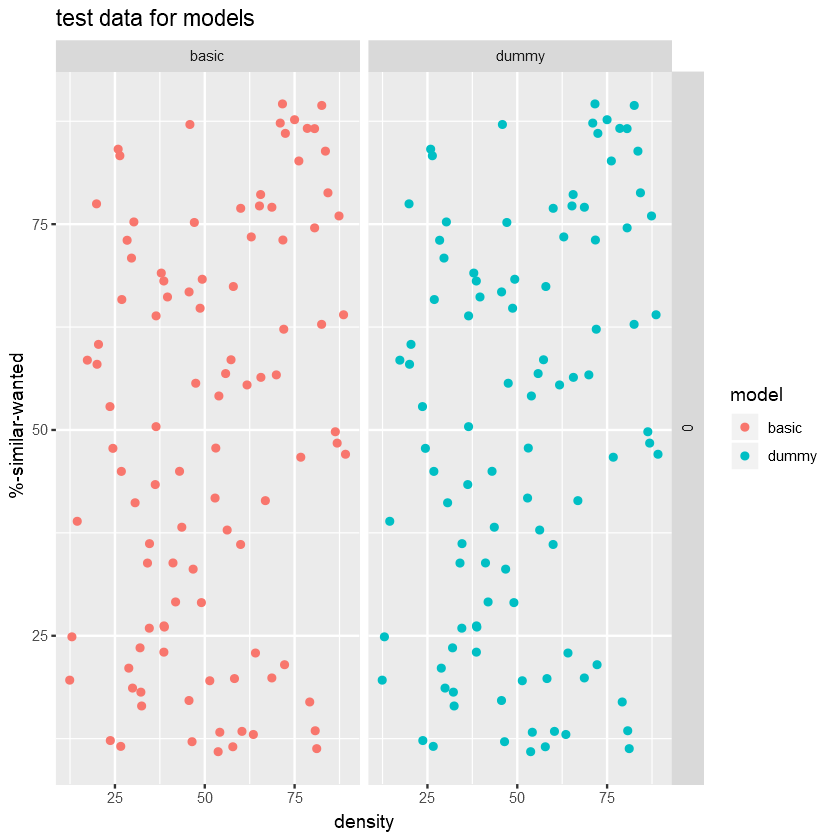

In [40]:
test_set_bind = rbind(data.table(test_set_all.1[,.(density,`%-similar-wanted`,seed)], model = model.type.1)
                     ,data.table(test_set_all.2[,.(density,`%-similar-wanted`,seed)], model = model.type.2))

test_set_plot = ggplot(data = test_set_bind, aes(x = density, y = `%-similar-wanted`)) +
                    geom_point(aes(color = model)) +
                    facet_grid(seed~model) +
                    ggtitle(paste0("test data for models"))
test_set_plot


Aynı seedler için basic'te de dummy'de de iki important feature'ın dağılımı aynı.

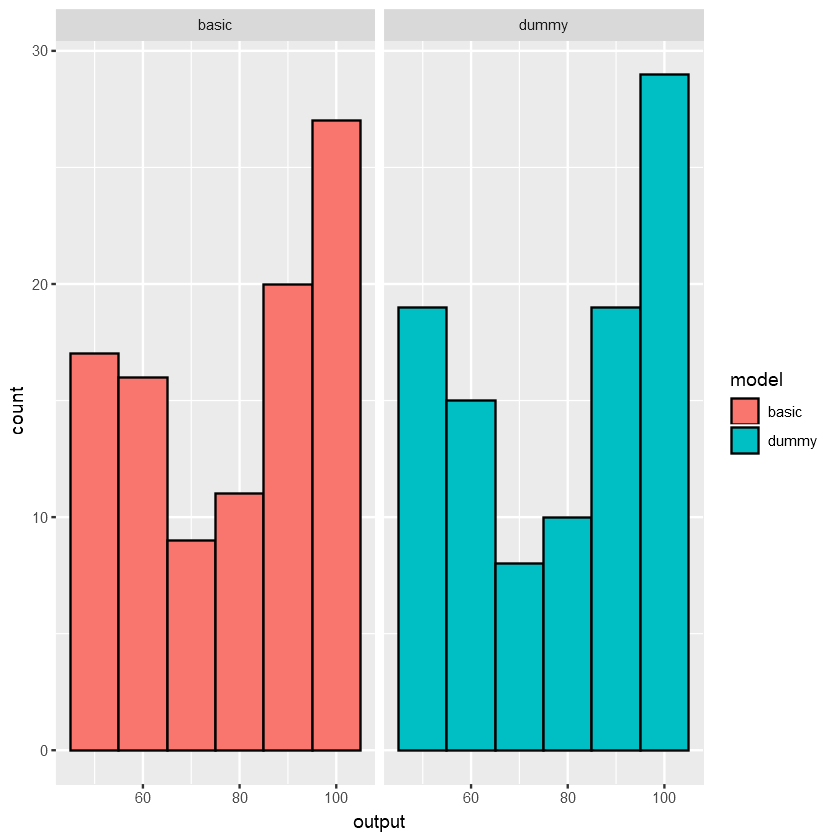

In [41]:
test_hist_data = rbind(data.table(test_set_all.1[,.(output)], model = model.type.1)
                            ,data.table(test_set_all.2[,.(output)], model = model.type.2))

ggplot(data =test_hist_data , aes(x = output, fill = model) ) +
        geom_histogram(position = "dodge", binwidth = 10, color = "black") + facet_wrap(~model)

# Oneshot Data

In [8]:
seed.oneshot.1 = c(0,1,2,3,4,5,6,7,8,20)
seed.oneshot.2 = c(0,1,2,3,4,5,6,7,8,20)
train_ins_oneshot = 100

In [9]:
training_set_all.1 = data.table()
for( i in seed.oneshot.1){
    
    training_set.name= paste0(data.path,"training_set","_",model.type.1,"_",train_ins_oneshot,"_seed",i,".csv")
    training_set <- fread(training_set.name) 

    training_set_all.1 = rbind(training_set_all.1,data.table(training_set, "seed" = i))
    rm(training_set,training_set.name)    
}

training_set_all.2 = data.table()
for( i in seed.oneshot.2){
    
    training_set.name= paste0(data.path,"training_set","_",model.type.2,"_",train_ins_oneshot,"_seed",i,".csv")
    training_set <- fread(training_set.name) 

    training_set_all.2 = rbind(training_set_all.2,data.table(training_set, "seed" = i))
    rm(training_set,training_set.name)    
}

In [10]:
one_shot_data.1 = copy(training_set_all.1)
one_shot_data.2 = copy(training_set_all.2)

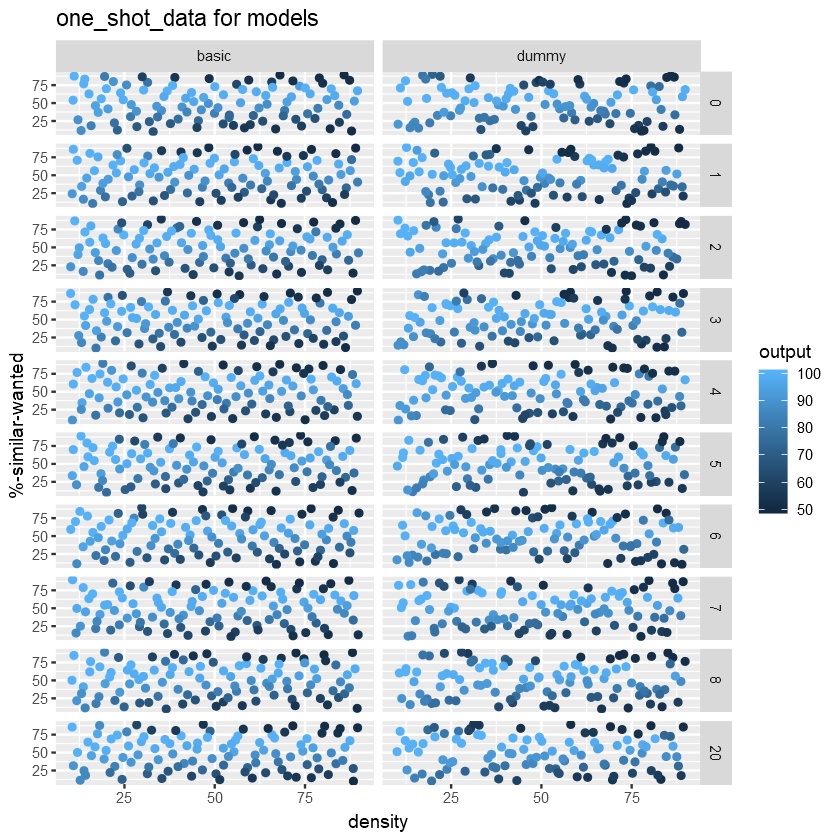

In [11]:
one_shot_bind = rbind(data.table(one_shot_data.1[,.(density,`%-similar-wanted`,seed,output)], model = model.type.1)
                     ,data.table(one_shot_data.2[,.(density,`%-similar-wanted`,seed,output)], model = model.type.2))
one_shot_plot = ggplot(data = one_shot_bind, aes(x = density, y = `%-similar-wanted`)) +
                    geom_point(aes(colour = output)) +
                    facet_grid(seed~model) +
                    labs(legend = "output") +
                    ggtitle(paste0("one_shot_data for models "))
one_shot_plot

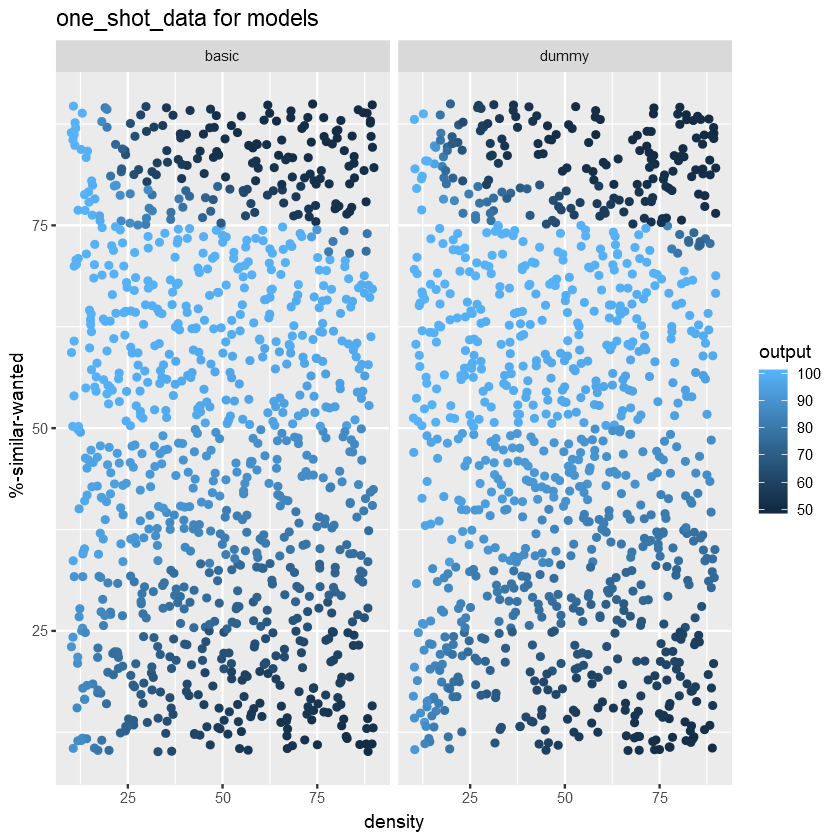

In [12]:
# Eğer üst üste koyarsak, 10 tane seed'in toplamda cover edemediği alanları rahatlıkla görebiliriz.
ggplot(data = one_shot_bind, aes(x = density, y = `%-similar-wanted`)) +
                    geom_point(aes(colour = output)) +
                    facet_grid(~model) +
                    labs(legend = "output") +
                    ggtitle(paste0("one_shot_data for models "))

In [13]:
oneshot_hist_data = rbind(data.table(one_shot_data.1[,.(output)], model = model.type.1)
                            ,data.table(one_shot_data.2[,.(output)], model = model.type.2))

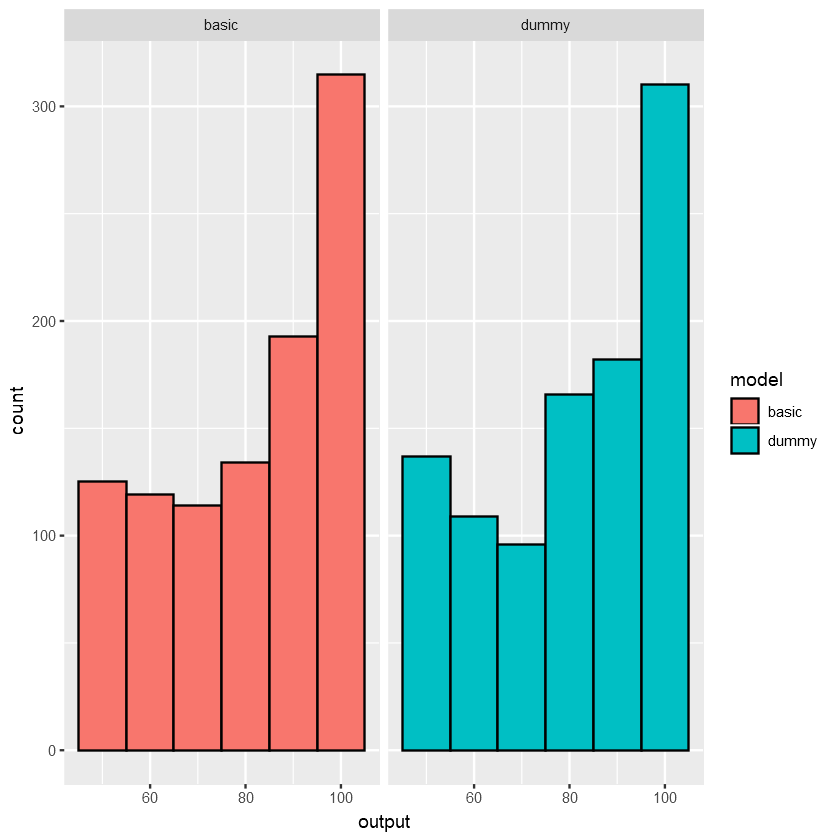

In [29]:
ggplot(data =oneshot_hist_data , aes(x = output, fill = model) ) +
        geom_histogram(position = "dodge", binwidth = 10, color = "black") + facet_wrap(~model)

In [14]:
head(oneshot_hist_data)

output,model
<dbl>,<chr>
93.88664,basic
58.75098,basic
73.61183,basic
89.48144,basic
65.44122,basic
57.97043,basic


# Adaptive Initial Data

In [31]:
seed.Ad.1 = c(0,1,2,3,4,5,6,7,8,20)
seed.Ad.2 = c(0,1,2,3,4,5,6,7,8,20)
train_ins_Ad = 50

In [32]:
training_set_Ad_all.1 = data.table()
for (i in seed.Ad.1) {
    
    training_set.name = paste0(data.path, "training_set", "_", model.type.1, "_", train_ins_Ad, "_seed", i, ".csv")
    training_set <- fread(training_set.name)
    
    training_set_Ad_all.1 = rbind(training_set_Ad_all.1, data.table(training_set, seed = i))
    rm(training_set, training_set.name)
}

training_set_Ad_all.2 = data.table()
for (i in seed.Ad.2) {
    
    training_set.name = paste0(data.path, "training_set", "_", model.type.2, "_", train_ins_Ad, "_seed", i, ".csv")
    training_set <- fread(training_set.name)
    
    training_set_Ad_all.2 = rbind(training_set_Ad_all.2, data.table(training_set, seed = i))
    rm(training_set, training_set.name)
}

In [33]:
adaptive_initial_data.1 = copy(training_set_Ad_all.1)
adaptive_initial_data.2 = copy(training_set_Ad_all.2)

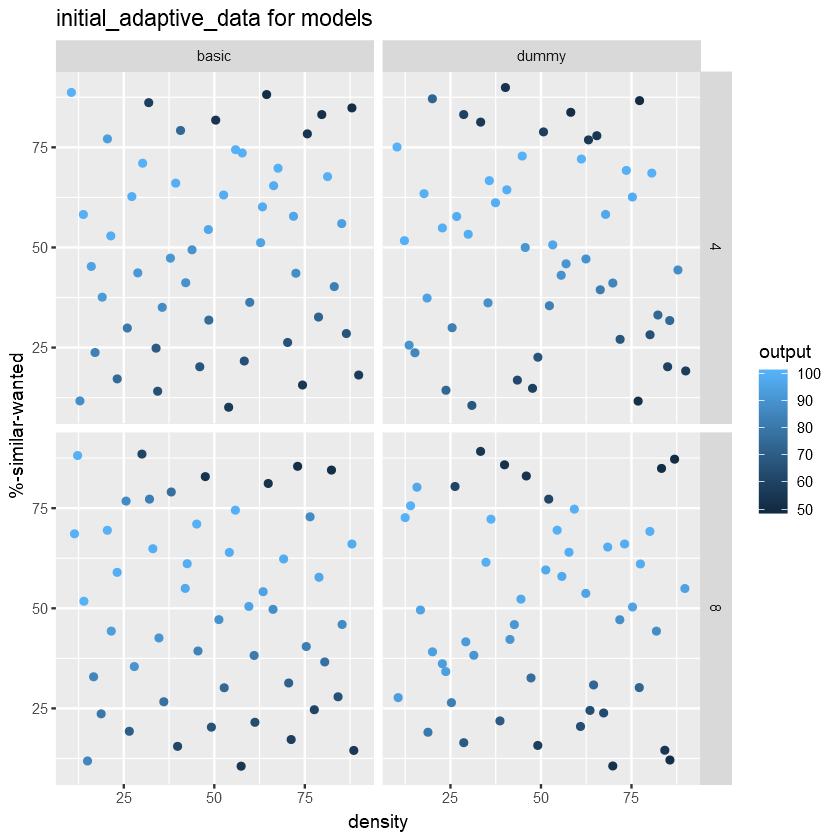

In [43]:
adaptive_initial_bind = rbind(data.table(adaptive_initial_data.1[,.(density,`%-similar-wanted`,seed,output)], model = model.type.1)
                             ,data.table(adaptive_initial_data.2[,.(density,`%-similar-wanted`,seed,output)], model = model.type.2))

adaptive_initial_plot = ggplot(data = adaptive_initial_bind[seed %in% c(4,8) ], aes(x = density, y = `%-similar-wanted`)) +
                           geom_point(aes(colour = output)) +
                           facet_grid(seed~model) +
                           labs(legend = "output") +
                           ggtitle(paste0("initial_adaptive_data for models "))
adaptive_initial_plot

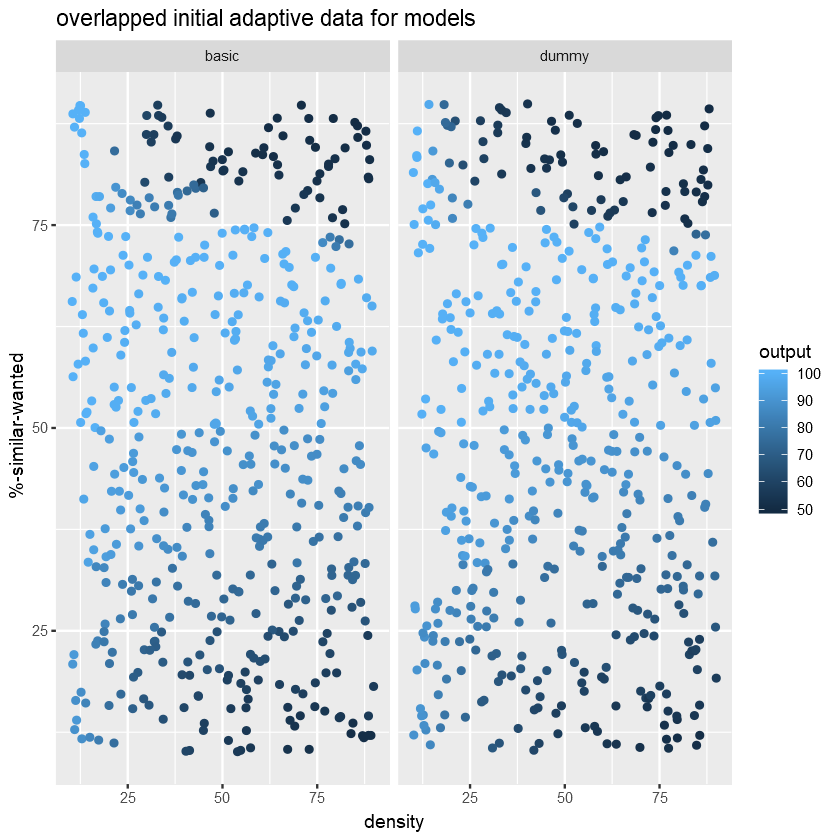

In [35]:
# Eğer üst üste koyarsak, 10 tane seed'in toplamda cover edemediği alanları rahatlıkla görebiliriz.
ggplot(data = adaptive_initial_bind, aes(x = density, y = `%-similar-wanted`)) +
                    geom_point(aes(colour = output)) +
                    facet_grid(~model) +
                    labs(legend = "output") +
                    ggtitle(paste0("overlapped initial adaptive data for models"))

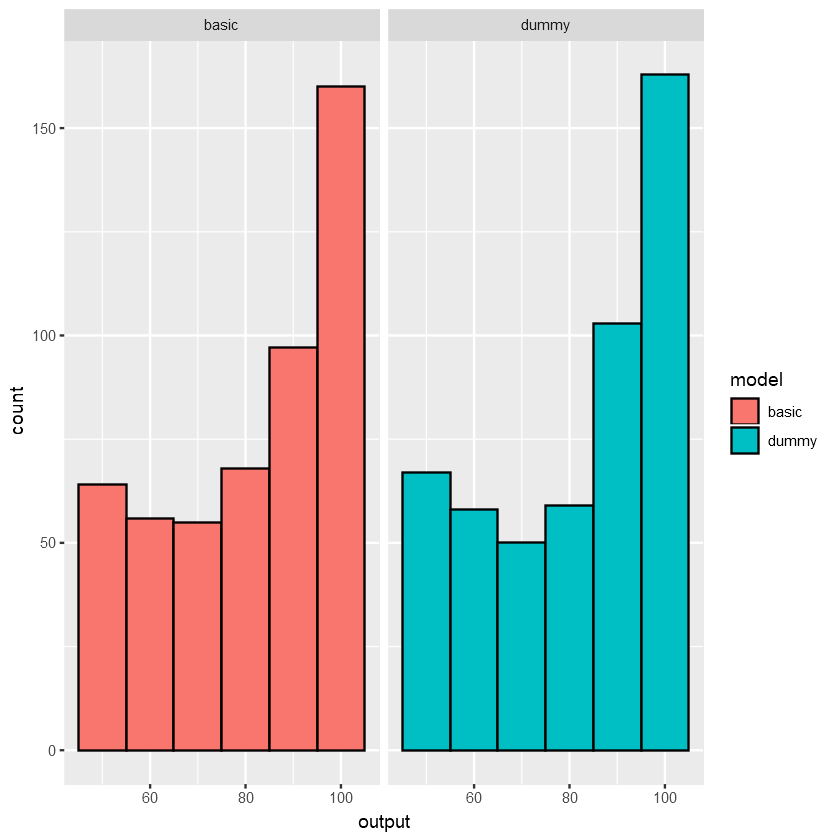

In [36]:
adaptive_hist_data = rbind(data.table(adaptive_initial_data.1[,.(output)], model = model.type.1)
                            ,data.table(adaptive_initial_data.2[,.(output)], model = model.type.2))

ggplot(data =adaptive_hist_data , aes(x = output, fill = model) ) +
        geom_histogram(position = "dodge", binwidth = 10, color = "black") + facet_wrap(~model)
